In [ ]:
!pip install datasets transformers -q
!pip install git+https://github.com/qubvel/segmentation_models.pytorch -q

In [ ]:
# Import libraries
import os
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp

from pprint import pprint
from torch.utils.data import DataLoader

In [ ]:
def set_all_seeds(seed: int=22) -> None:
    '''
    sets all random states to enforce reproducibility

    Parameters:
    -----------
        seed (int):
            random state to use
    '''

    # python's seeds
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

    # torch's seeds
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

magic_seed = 22
set_all_seeds(seed=magic_seed)

# Dataset

In [ ]:
from datasets import load_dataset

# Load our saved dataset from HuggingFace
hf_dataset_identifier = "Mauregato/leaf_disease_segmentation"
dataset = load_dataset(hf_dataset_identifier)

In [ ]:
# Dataset structure
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'mask'],
        num_rows: 2205
    })
    val: Dataset({
        features: ['image', 'mask'],
        num_rows: 294
    })
    test: Dataset({
        features: ['image', 'mask'],
        num_rows: 441
    })
})

In [ ]:
train_dataset = dataset['train']
valid_dataset = dataset['val']
test_dataset = dataset['test']

In [ ]:
from torchvision import transforms

# params = smp.encoders.get_preprocessing_params('efficientnet-b4')
def train_transforms(example_batch):
    '''
    performs transforms on train batch

    Parameters:
    -----------
        example_batch:
            train batch to process

    Return:
    -------
        inputs:
            processed train batch
    '''

    image_transforms = transforms.Compose([
          transforms.ToTensor(),
          transforms.Resize(size=(512, 512)),
          transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225]),
        ])

    mask_transforms = transforms.Compose([
          transforms.ToTensor(),
          transforms.Resize(size=(512, 512)),
        ])

    processed_images = [image_transforms(x) for x in example_batch['image']]
    processed_masks = [mask_transforms(x) for x in example_batch['mask']]

    # There are int values greater that 1 in some masks. Let's fix it.
    for mask in processed_masks:
        mask[mask > 0] = 1

    inputs = {'image': processed_images, 'mask': processed_masks}

    return inputs

def val_transforms(example_batch):
    '''
    performs transforms on validation batch

    Parameters:
    -----------
        example_batch:
            validation batch to process

    Return:
    -------
        inputs:
            processed validation batch
    '''

    image_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(size=(512, 512)),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
      ])

    mask_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(size=(512, 512)),
      ])

    processed_images = [image_transforms(x) for x in example_batch['image']]
    processed_masks = [mask_transforms(x) for x in example_batch['mask']]

    # There are int values greater that 1 in some masks. Let's fix it.
    for mask in processed_masks:
        mask[mask > 0] = 1

    inputs = {'image': processed_images, 'mask': processed_masks}

  return inputs

In [ ]:
# Set transforms for datasets
train_dataset.set_transform(train_transforms)
valid_dataset.set_transform(val_transforms)
test_dataset.set_transform(val_transforms)

In [ ]:
# Let's ensure transforms were applied right
sample = train_dataset[0]
sample_image = sample['image']
sample_mask = sample['mask']

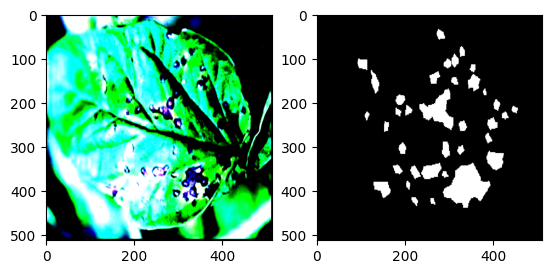

In [ ]:
plt.subplot(1,2,1)
plt.imshow(sample_image.permute(1, 2, 0)) # for visualization we have to transpose back to HWC
plt.subplot(1,2,2)
plt.imshow(sample_mask.squeeze(), cmap='gray')  # for visualization we have to remove 3rd dimension of mask
plt.show()

In [ ]:
sample_image.shape

torch.Size([3, 512, 512])

In [ ]:
# Model hyperparameters
class CFG:
    lr=0.00006
    batch_size=5
    num_workers=os.cpu_count()
    epochs=10
    num_chanels=sample_image.shape[0]
    num_class=1

In [ ]:
print(f"Train size: {len(train_dataset)}")
print(f"Valid size: {len(valid_dataset)}")
print(f"Test size: {len(test_dataset)}")

train_datasets = {'train': train_dataset,
                  'val': valid_dataset}

dataloaders_dict = {x: torch.utils.data.DataLoader(train_datasets[x],
                                                   batch_size=CFG.batch_size,
                                                   shuffle=True,
                                                   num_workers=CFG.num_workers)
                    for x in ['train', 'val']}

Train size: 2205
Valid size: 294
Test size: 441


# Model

In [ ]:
def count_parameters(model):
    '''
    counts number of trainable parameters of the model

    Parameters:
    -----------
        model:
            model to use for fine-tuning

    Return:
    -------
        number of trainable parameters
    '''
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
from torch import nn
import copy
from collections import defaultdict
from tqdm.notebook import tqdm, trange
from sklearn.metrics import jaccard_score, cohen_kappa_score

# функция для тренировки, на выходе - обученная модель
def train_model(model, dataloaders,
                criterion, optimizer, scheduler, num_epochs=25,
                early_stopping_rounds=5, verbose=1, batch_size=5):
    '''
    performs training procedure for the model

    Parameters:
    -----------
        model:
            model to use for training

        dataloaders:
            dict containing train and validation datasets as the values
            to perform training and validation on each epoch

        criterion:
            loss function used for training

        optimizer:
            optimizer used for training

        scheduler:
            scheduler determining the rule of changing of learning rate

        num_epochs:
            number of epochs of training

        early_stopping_rounds:
            number of epochs during which the target metric is expected
            to be better. If it is not the case, the training is stopped

        verbose:
            period of output training stats

        batch_size:
            batch size for datasets

    Return:
    -------
        model:
            trainable model showed best perfomance during training

        metrics_values:
            training stats
    '''


    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = np.inf
    best_iou = 0
    early_steps = 0
    metrics_value = defaultdict(list)
    stop = False


    for epoch in trange(num_epochs, desc='Epochs'):
        if stop:
            break
        if epoch % verbose == 0:
            print('Epoch {}/{}'.format(epoch, num_epochs - 1))
            print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:

            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            iou_score = 0.0
            dice_score = 0.0
            kappa_score = 0.0
            # Iterate over data.
            for objects in tqdm(dataloaders[phase],
                                       desc='Iterating through dataloader',
                                       leave=False):
                images = objects['image']
                masks = objects['mask']
                images = images.to(device)
                masks = masks.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss

                    outputs = model(images)

                    loss = criterion(outputs, masks)

                    preds = (outputs > 0.5).float()

                    iou_per_batch = jaccard_score(masks.cpu().detach().numpy().flatten(),
                                               preds.cpu().detach().numpy().flatten())

                    iou_score += iou_per_batch

                    dice_score += iou_per_batch * 2 / (iou_per_batch + 1)

                    kappa_score += cohen_kappa_score(masks.cpu().detach().numpy().flatten(),
                                               preds.cpu().detach().numpy().flatten())

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        scheduler.step()

                # statistics
                running_loss += loss.item() * images.size(0)
                val_acc_history.append(running_loss)

            # Mean stats among epoch
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_iou = iou_score / (len(dataloaders[phase]))
            epoch_dice = dice_score / (len(dataloaders[phase]))
            epoch_kappa = kappa_score / (len(dataloaders[phase]))

            metrics_value['MAE'].append(epoch_loss)
            metrics_value['IoU'].append(epoch_iou)
            metrics_value['Dice'].append(epoch_dice)
            metrics_value['Kappa'].append(epoch_kappa)
            if epoch % verbose == 0:
                print('{} Loss: {:.4f} IoU: {:.4f} Dice: {:.4f} Kappa: {:.4f}'.format(
                        phase, epoch_loss, epoch_iou, epoch_dice, epoch_kappa))

            # deep copy the model
            if phase == 'val' and epoch_iou > best_iou:
                best_model_wts = copy.deepcopy(model.state_dict())
                best_iou = epoch_iou
                early_steps = 0
            if phase == 'val' and epoch_iou < best_iou:
                early_steps += 1
                if early_steps > early_stopping_rounds:
                    stop = True
                    print(f'Stopped by early_stopping. Epoch: {epoch}')
                    print(f'Best metric = {best_iou}')
                    break


    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, metrics_value

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:', device)

device: cpu


In [ ]:
from transformers import get_linear_schedule_with_warmup

# Training hyperparameters
optimizer = torch.optim.AdamW(model.parameters(), lr=CFG.lr)
criterion = nn.BCELoss().to(device)
num_warmup_steps = 0
num_training_steps = len(train_dataset) // CFG.batch_size * CFG.epochs
scheduler = get_linear_schedule_with_warmup(optimizer=optimizer,
                                            num_warmup_steps=num_warmup_steps,
                                            num_training_steps=num_training_steps)

## U-Net + EfficientNet-b4

In [ ]:
# Choose encoder
encoder_name = 'efficientnet_b4'

# Load preatrained model
model = smp.create_model(arch="Unet", encoder_name=encoder_name, in_channels=3,
                         activation='sigmoid', classes=1, encoder_weights='imagenet').to(device)

count_parameters(model)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 55.1MB/s]


24436369

In [ ]:
model_ft, metrics = train_model(model, dataloaders_dict,
                                criterion, optimizer, scheduler,
                                num_epochs=CFG.epochs, batch_size=CFG.batch_size)

## U-Net + ResNet-34

In [ ]:
# Choose encoder
encoder_name = 'resnet34'

# Load preatrained model
model = smp.create_model(arch="Unet", encoder_name=encoder_name, in_channels=3,
                         activation='sigmoid', classes=1, encoder_weights='imagenet').to(device)

count_parameters(model)

In [ ]:
model_ft, metrics = train_model(model, dataloaders_dict,
                                criterion, optimizer, scheduler,
                                num_epochs=CFG.epochs, batch_size=CFG.batch_size)

## U-Net++ + resnet-34

In [ ]:
# Choose encoder
encoder_name = 'resnet34'

# Load preatrained model
model = smp.create_model(arch="Unetplusplus", encoder_name=encoder_name, in_channels=3,
                         activation='sigmoid', classes=1, encoder_weights='imagenet').to(device)
count_parameters(model)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 185MB/s]


26078609

In [ ]:
model_ft, metrics = train_model(model, dataloaders_dict,
                                criterion, optimizer, scheduler,
                                num_epochs=CFG.epochs, batch_size=CFG.batch_size)

# Results

In [ ]:
# Best validation results

# UNet + ResNet-34
'''
IoU: 0.7925
Dice: 0.8824
Kappa: 0.86
'''

# UNet + EfficientNet-b4
'''
IoU: 0.8155
Dice: 0.8974
Kappa: 0.8787
'''

# UNet++ + ResNet-34
'''
IoU: 0.7993
Dice: 0.8867
Kappa: 0.8659
'''

# Графика

## U-Net++

In [ ]:
train_mae_scores = [score for i, score in enumerate(metrics['MAE']) if i % 2 == 0]
val_mae_scores = [score for i, score in enumerate(metrics['MAE']) if i % 2 == 1]

train_iou_scores = [score for i, score in enumerate(metrics['IoU']) if i % 2 == 0]
val_iou_scores = [score for i, score in enumerate(metrics['IoU']) if i % 2 == 1]

train_dice_scores = [score for i, score in enumerate(metrics['Dice']) if i % 2 == 0]
val_dice_scores = [score for i, score in enumerate(metrics['Dice']) if i % 2 == 1]


train_kappa_scores = [score for i, score in enumerate(metrics['Kappa']) if i % 2 == 0]
val_kappa_scores = [score for i, score in enumerate(metrics['Kappa']) if i % 2 == 1]


In [ ]:
train_stats = [train_mae_scores, train_iou_scores, train_dice_scores, train_kappa_scores]
val_stats = [val_mae_scores, val_iou_scores, val_dice_scores, val_kappa_scores]

In [ ]:
metric_name = {0: 'mae', 1: 'iou', 2: 'dice', 3: 'kappa'}

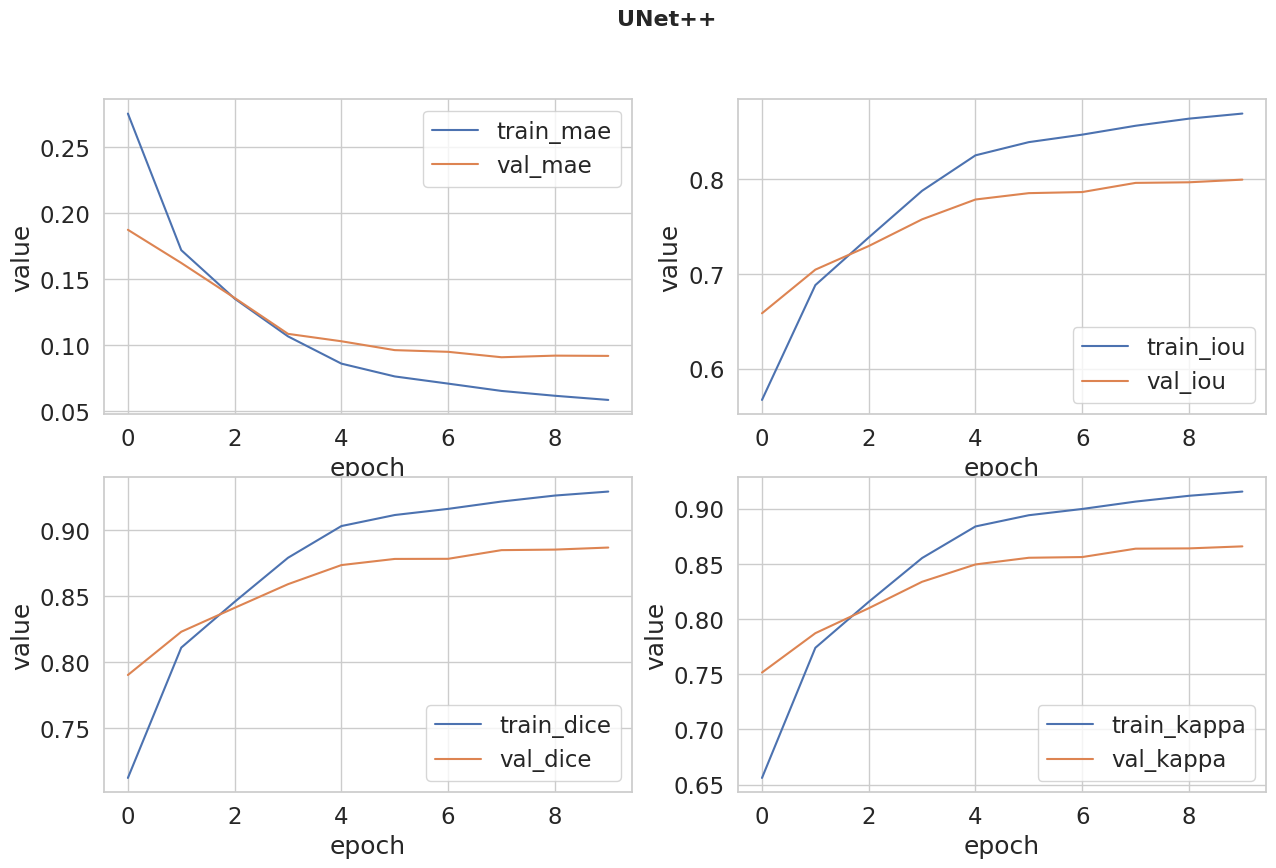

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='whitegrid', font_scale=1.5)

fig, axs = plt.subplots(2, 2, figsize=(15,9))
fig.suptitle('UNet++', fontsize=16, fontweight='bold')

for i in range(4):
    axs[i // 2, (i % 2)].plot(train_stats[i], label=f'train_{metric_name[i]}')
    axs[i // 2, (i % 2)].plot(val_stats[i], label=f'val_{metric_name[i]}')
    axs[i // 2, (i % 2)].legend(loc='best')

# set labels
plt.setp(axs, xlabel='epoch')
plt.setp(axs, ylabel='value');

## Efficientnet-b4 + U-Net

In [ ]:
train_mae_scores = [score for i, score in enumerate(metrics['MAE']) if i % 2 == 0]
val_mae_scores = [score for i, score in enumerate(metrics['MAE']) if i % 2 == 1]

train_iou_scores = [score for i, score in enumerate(metrics['IoU']) if i % 2 == 0]
val_iou_scores = [score for i, score in enumerate(metrics['IoU']) if i % 2 == 1]

train_dice_scores = [score for i, score in enumerate(metrics['Dice']) if i % 2 == 0]
val_dice_scores = [score for i, score in enumerate(metrics['Dice']) if i % 2 == 1]


train_kappa_scores = [score for i, score in enumerate(metrics['Kappa']) if i % 2 == 0]
val_kappa_scores = [score for i, score in enumerate(metrics['Kappa']) if i % 2 == 1]


In [ ]:
train_stats = [train_mae_scores, train_iou_scores, train_dice_scores, train_kappa_scores]
val_stats = [val_mae_scores, val_iou_scores, val_dice_scores, val_kappa_scores]

In [ ]:
metric_name = {0: 'mae', 1: 'iou', 2: 'dice', 3: 'kappa'}

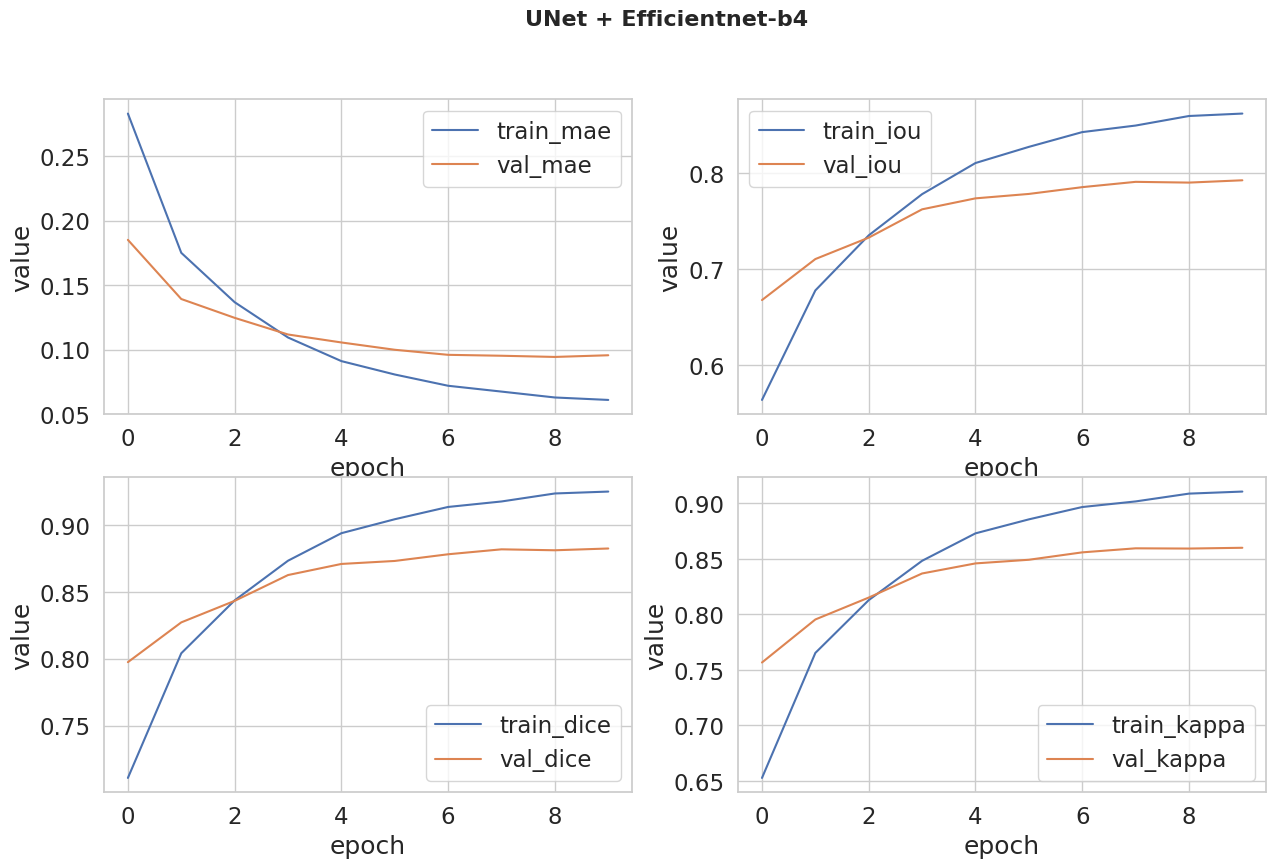

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='whitegrid', font_scale=1.5)

fig, axs = plt.subplots(2, 2, figsize=(15,9))
fig.suptitle('UNet + Efficientnet-b4', fontsize=16, fontweight='bold')

for i in range(4):
    axs[i // 2, (i % 2)].plot(train_stats[i], label=f'train_{metric_name[i]}')
    axs[i // 2, (i % 2)].plot(val_stats[i], label=f'val_{metric_name[i]}')
    axs[i // 2, (i % 2)].legend(loc='best')

# set labels
plt.setp(axs, xlabel='epoch')
plt.setp(axs, ylabel='value');

## ResNet34 + U-Net

In [ ]:
import json

with open('learning_stats.json', 'r') as fi:
  data = json.load(fi)

In [ ]:
stats = data['MAE']
stats

In [ ]:
train_mae_scores = [score for i, score in enumerate(stats) if i % 8 == 0]
train_iou_scores = [score for i, score in enumerate(stats) if i % 8 == 1]
train_dice_scores = [score for i, score in enumerate(stats) if i % 8 == 2]
train_kappa_scores = [score for i, score in enumerate(stats) if i % 8 == 3]

val_mae_scores = [score for i, score in enumerate(stats) if i % 8 == 4]
val_iou_scores = [score for i, score in enumerate(stats) if i % 8 == 5]
val_dice_scores = [score for i, score in enumerate(stats) if i % 8 == 6]
val_kappa_scores = [score for i, score in enumerate(stats) if i % 8 == 7]

In [ ]:
train_dice_scores = [2 * score / (score + 1) for score in train_iou_scores]
val_dice_scores = [2 * score / (score + 1) for score in val_iou_scores]

In [ ]:
train_stats = [train_mae_scores, train_iou_scores, train_dice_scores, train_kappa_scores]
val_stats = [val_mae_scores, val_iou_scores, val_dice_scores, val_kappa_scores]

In [ ]:
metric_name = {0: 'mae', 1: 'iou', 2: 'dice', 3: 'kappa'}

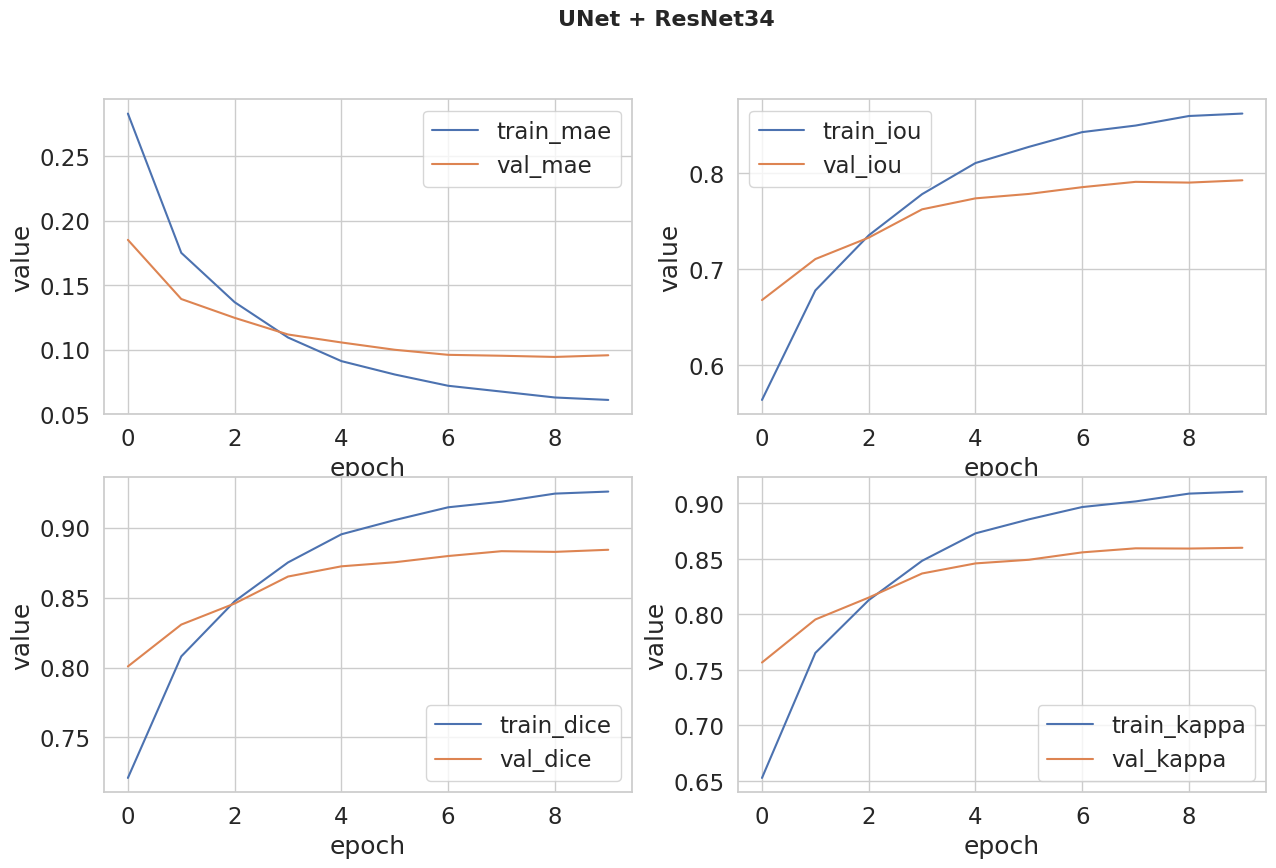

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(15,9))
fig.suptitle('UNet + ResNet34', fontsize=16, fontweight='bold')

for i in range(4):
    axs[i // 2, (i % 2)].plot(train_stats[i], label=f'train_{metric_name[i]}')
    axs[i // 2, (i % 2)].plot(val_stats[i], label=f'val_{metric_name[i]}')
    axs[i // 2, (i % 2)].legend(loc='best')

# set labels
plt.setp(axs, xlabel='epoch')
plt.setp(axs, ylabel='value');